In [1]:
import multiprocess as mp
import tqdm
import numpy as np
from astropy.table import Table

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# SOM Training and Classification

Now we do the same thing with the Deep Data..

In [2]:
from NoiseSOM import *
from pipeline_tools import *

## Training

In [3]:
fname = '../data/deep_field_data/BFD/TRAIN_CAT_5E+04.fits'
t = Table.read(fname, format='fits')
list(t.keys())

['id_array',
 'bdf_mag_ugriz',
 'bdf_flux_ugriz',
 'bdf_params',
 'bdf_ra',
 'bdf_dec',
 'des_id',
 'Laigle_mag_dered_ugrizYJHK',
 'Laigle_fluxes_dered_ugrizYJHK',
 'BFD_fluxes_ugriz',
 'DESD_flux_ugrizjhk',
 'DESD_flux_ugrizjhk_err',
 'COSMOS_ID',
 'COSMOS_PHOTZ',
 'COSMOS_type']

In [4]:
fluxes_colname = 'DESD_flux_ugrizjhk'
fluxes_err_colname = 'DESD_flux_ugrizjhk_err'

fluxes = t[fluxes_colname].data
fluxes_err = t[fluxes_err_colname].data

In [5]:
CAT_TYPE = 'BFD'
out_path = '../outputs/%s_deep/'%CAT_TYPE

deepres = 64

if not os.path.exists(out_path): os.mkdir(out_path)

__*Note:*__ Training the deep SOM might kill the notebook. If this happens, run the following:

```
cd path/to/SOM-photoz-BFD/src
python 3_deep_train.py
```

This is just a script version of the necesities, once it's trained you should be able to just load the weights in this notebook

In [8]:
if not os.path.exists(out_path+'SOM.pkl'):
    nTrain=fluxes.shape[0]
    hh = hFunc(nTrain,sigma=(30,1))
    metric = AsinhMetric(lnScaleSigma=0.4,lnScaleStep=0.03)
    indices = np.random.choice(fluxes.shape[0],size=nTrain,replace=False)
    som = NoiseSOM(metric,fluxes[indices,:],fluxes_err[indices,:], \
                                learning=hh, \
                                shape=(deepres,deepres), \
                                wrap=False,logF=True, \
                                initialize='sample', \
                                minError=0.02)

    som.train()
    som.save(path=out_path)
else:
    print("loading SOM from %sSOM.pkl"%out_path)
    som = load_SOM(out_path+'SOM.pkl')

loading SOM from ../outputs/BFD_deep/SOM.pkl


## Classification 

Now that the SOM is trained, we will use the validation catalog to ensure that the SOM algorithm worked correctly.

In [9]:
fname = '../data/deep_field_data/BFD/VALIDATION_cat_5E+04.fits'
t = Table.read(fname, format='fits')

### Assigning Galaxies to Cells

Now we're going to run the Noise_SOM `classify` function to classify the random subset of the catalog. This can be done in parallel, so let's define a function that can be run in multiprocessing:

In [10]:
num_inds = 1000
inds = np.array_split(np.arange(len(t[fluxes_colname])),num_inds)
def assign_som(index):
    cells_test, _ = som.classify(t[fluxes_colname][inds[index]], 
                                     t[fluxes_err_colname][inds[index]])
    
    return cells_test

In [11]:
# Now running the multiprocessing pool (this can take a few minutes)
def run_pools():
    p = mp.Pool(7)
    
    filename = "%s/assignments.pkl"%out_path
    if not os.path.exists(filename):
        print("Assigning Galaxies...")
        args = [(i,) for i in range(num_inds)]
        assignments = list(tqdm.tqdm(p.imap(assign_som, range(num_inds)), total=num_inds))
        with open(filename, 'wb') as f:
            pickle.dump(assignments, f)
            f.close()
    else:
        print("Loading Galaxy Assignments...")
        with open(filename, 'rb') as f:
            assignments = pickle.load(f)
        
    print("Done")
    return assignments
    
    
if __name__ == '__main__':
    all_results = run_pools()
    
    assignments = []
    for res in all_results:
        assignments = np.append(assignments,res)
    
    t['Deep Cell Assignment'] = assignments

/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)
/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)


Assigning Galaxies...


  0%|          | 0/1000 [00:00<?, ?it/s]/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)
/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)
/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)
/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)
/global/homes/d/dncross/SOMs/SOM-photoz-BFD/src/NoiseSOM.py:435: RuntimeWarning: overflow encountered in exp
  w = np.minimum(np.exp(2*(vf-4)),1000.)
100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]

Done


### Calculating aggregate properties of the galaxies in each cell

In [12]:
# ensure all cells have at least one "dummy" galaxy
dummy_row = [0]*(len(t.colnames)) 
dc_idx = np.where('Deep Cell Assignment'==np.array(t.colnames))[0][0]
fluxes_idx = np.where('DESD_flux_ugrizjhk'==np.array(t.colnames))[0][0]
dummy_row[fluxes_idx] = [np.nan]*len('ugrizjhk')

for dc in range(deepres*deepres): 
    dummy_row[dc_idx] = dc
    t.add_row(dummy_row)

In [13]:
mags = flux_to_mag(t[fluxes_colname].data)
bands = list('ugrizjhk')
for i,b in enumerate(bands):
    t['%s_mag'%b] = mags[:,i]
    
colors = ['%s-%s'%(f,n) for f,n in zip('ugrizjhk', 'grizjhk')]
for i, c in enumerate(colors):
    t[c] = mags[:,i]-mags[:,i+1]

def masked_nanmean(col):
    return np.nanmean(col[(col<np.inf)&(col>-np.inf)])

def masked_nanstd(col):
    return np.nanstd(col[(col<np.inf)&(col>-np.inf)])

grouped_by_wc = t.group_by('Deep Cell Assignment')
averages = grouped_by_wc.groups.aggregate(masked_nanmean)
stddev = grouped_by_wc.groups.aggregate(masked_nanstd)

/tmp/ipykernel_1647051/2529734779.py:11: RuntimeWarning: Mean of empty slice
  return np.nanmean(col[(col<np.inf)&(col>-np.inf)])
/global/homes/d/dncross/.conda/envs/BFD/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [14]:
empty_cells = np.where(np.abs(np.array((averages['u-g'] < np.inf), dtype=int)-1))

## Plots!

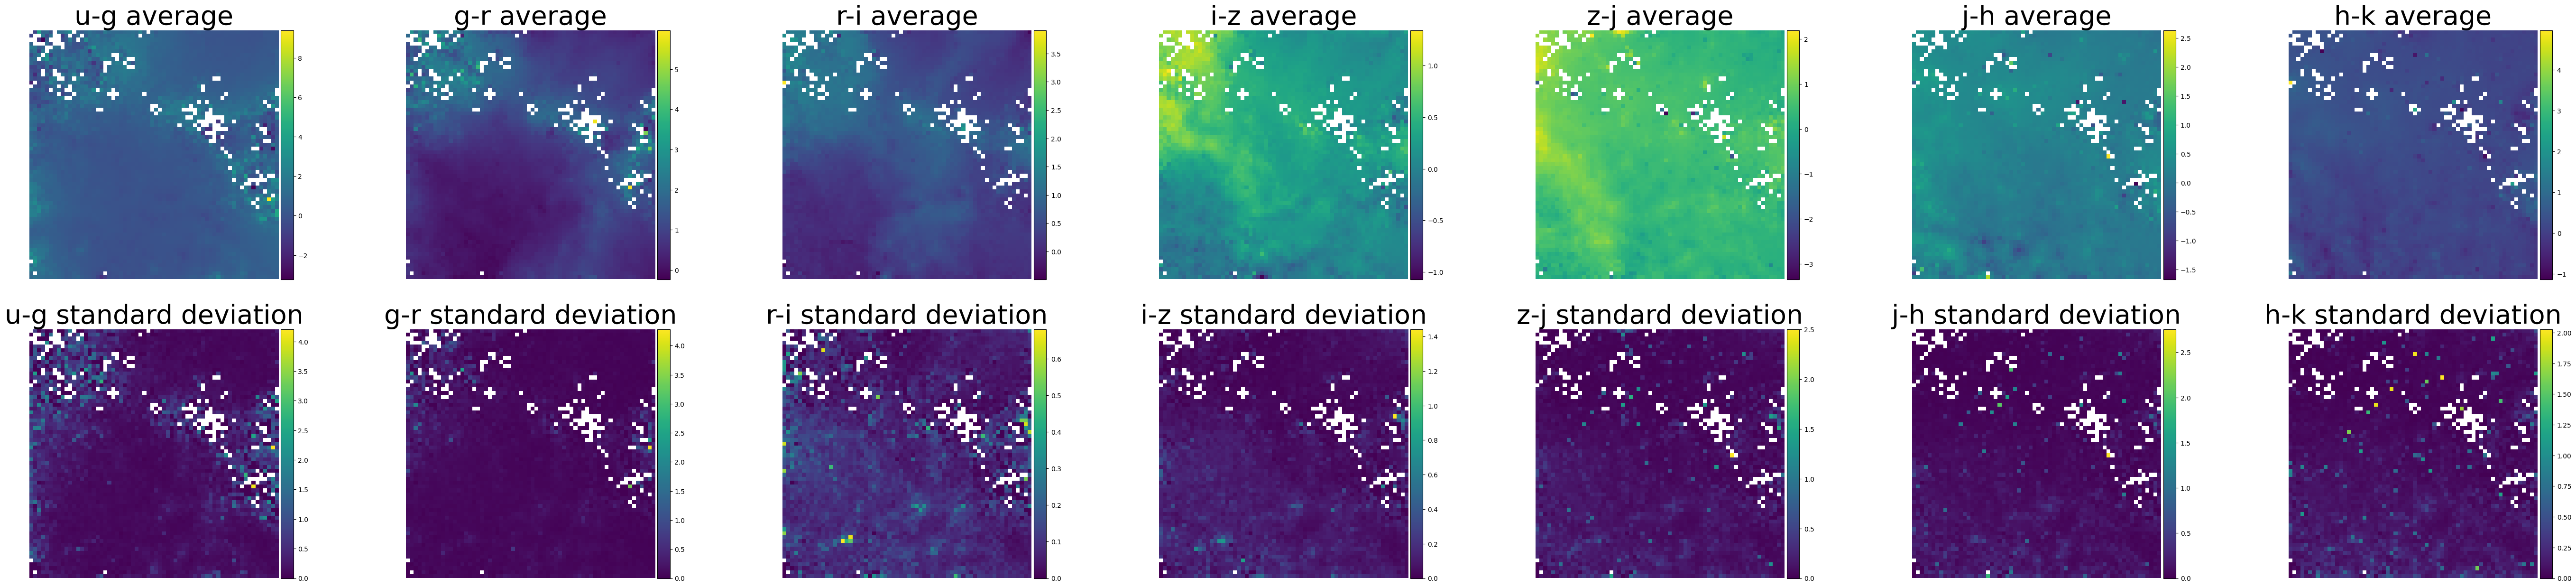

In [15]:
fig, axs = plt.subplots(2,len(colors), figsize=(len(colors)*10,15))

for a,c in zip(axs.T,colors):
    
    im0=a[0].imshow(averages[c].reshape(deepres,deepres)) ; a[0].set_title(label=c+' average', fontsize=40)
    im1=a[1].imshow(stddev[c].reshape(deepres,deepres)) ; a[1].set_title(label=c+' standard deviation', fontsize=40)
    
    a[0].axis('off')
    a[1].axis('off')
    
    divider = make_axes_locatable(a[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(a[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
plt.show()

Text(0.5, 0.98, 'Deep Field Redshifts')

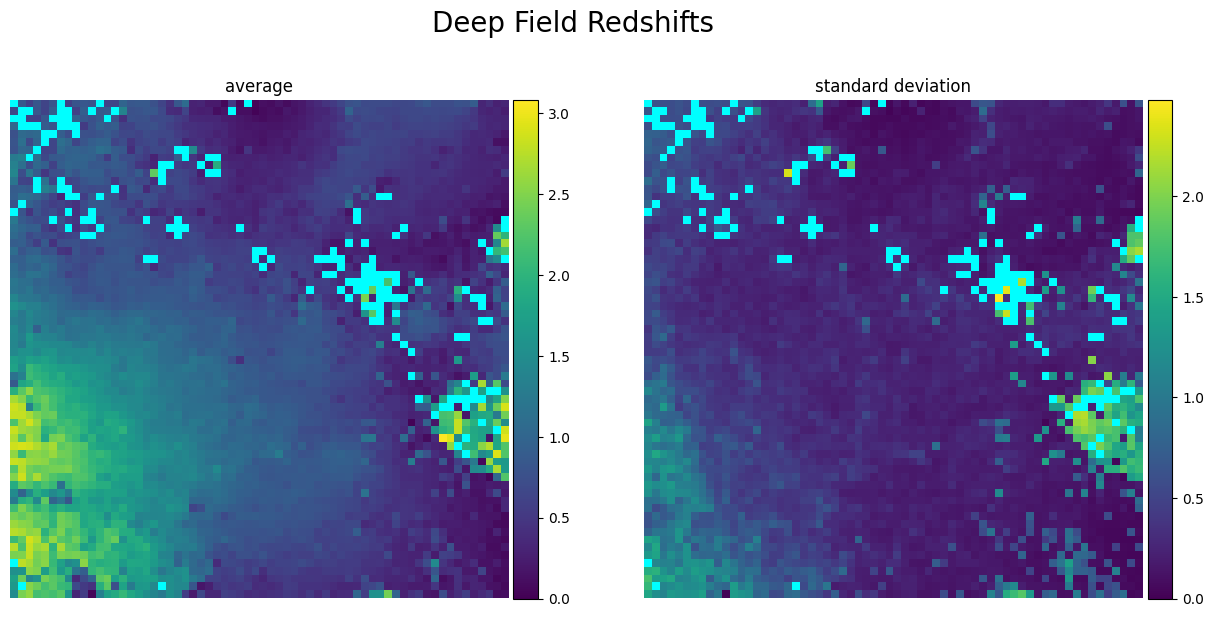

In [16]:
fig, a = plt.subplots(1,2,figsize=(15,7))

im0=a[0].imshow(averages['COSMOS_PHOTZ'].reshape(deepres,deepres)) ; a[0].set_title(label='average')
im1=a[1].imshow(stddev['COSMOS_PHOTZ'].reshape(deepres,deepres)) ; a[1].set_title(label='standard deviation')

mask = np.zeros((deepres*deepres))
mask[:] = np.nan
mask[empty_cells] = 1
a[0].imshow(mask.reshape(deepres,deepres), cmap='cool')
a[1].imshow(mask.reshape(deepres,deepres), cmap='cool')

a[0].axis('off')
a[1].axis('off')

divider = make_axes_locatable(a[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

divider = make_axes_locatable(a[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.suptitle("Deep Field Redshifts", fontsize=20)

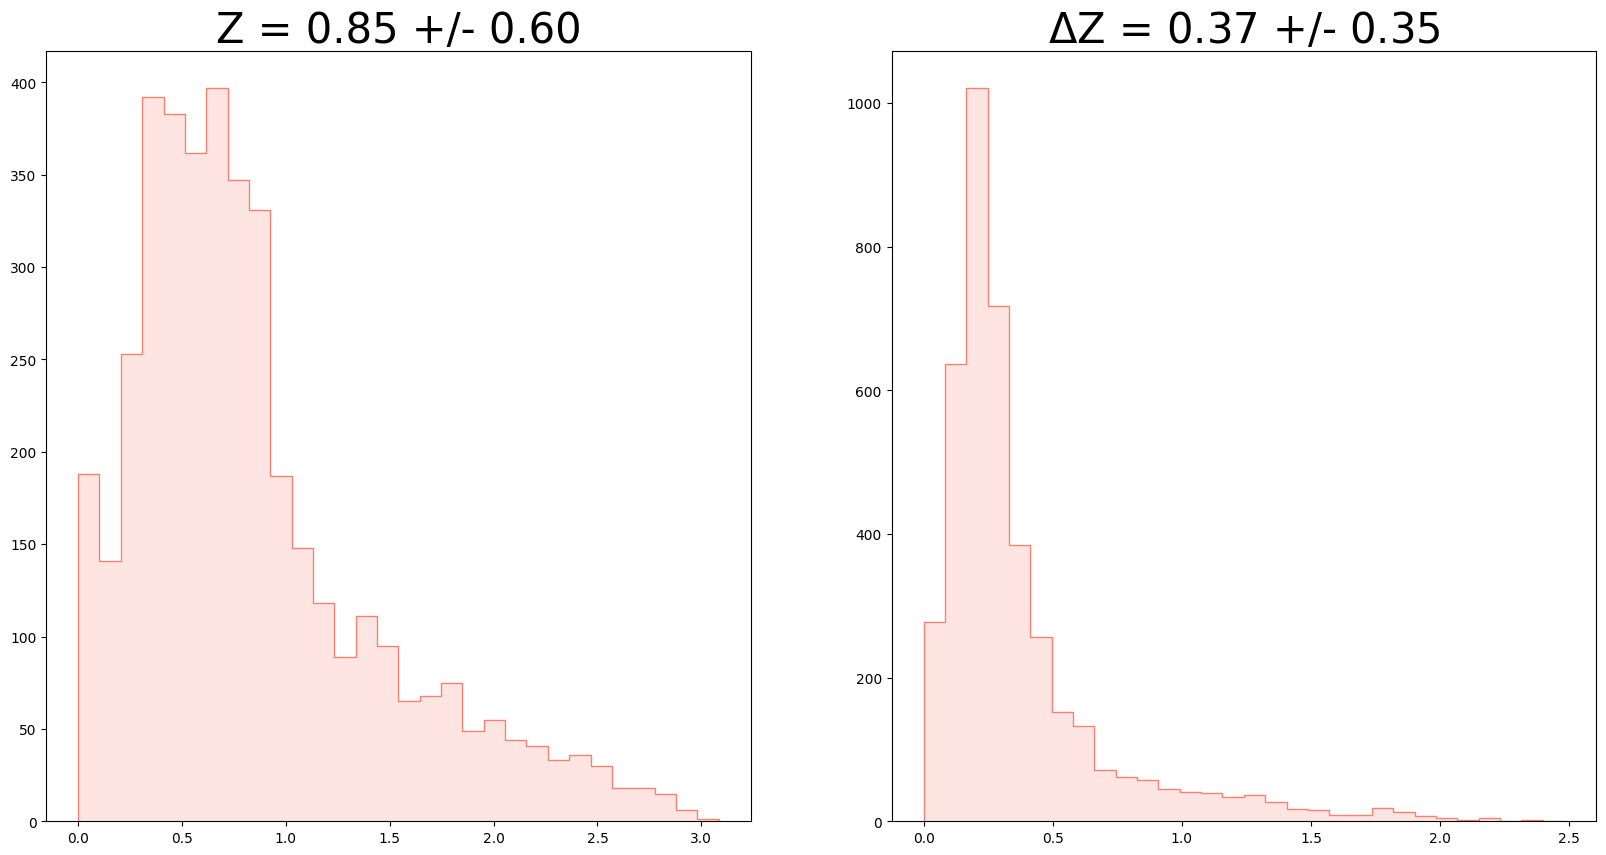

In [17]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
c = 'salmon'

axs[0].hist(averages['COSMOS_PHOTZ'], 30, histtype='step', color=c)
axs[1].hist(stddev['COSMOS_PHOTZ'], 30, histtype='step', color=c)

axs[0].hist(averages['COSMOS_PHOTZ'], 30, alpha=0.2, color=c)
axs[1].hist(stddev['COSMOS_PHOTZ'], 30, alpha=0.2, color=c)

axs[0].set_title('Z = %.02f +/- %.02f'%(np.average(averages['COSMOS_PHOTZ']), np.std(averages['COSMOS_PHOTZ'])), fontsize=30)
axs[1].set_title(r'$\Delta$Z = %.02f +/- %.02f'%(np.average(stddev['COSMOS_PHOTZ']), np.std(stddev['COSMOS_PHOTZ'])), fontsize=30)

pl.show()